Модуль для детекции автомобильного номера на изображении. Нейросеть обучена на изображениях формата .jpg размером 1280\*720 и 1920\*1080. Маски подготовлены с помощью программы LabelImg.

In [ ]:
# коллабные импорты
from google.colab import drive
from google.colab import files


drive.mount('/GD',force_remount=True)
!cp -r /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/data.zip .
!unzip data.zip
!ls

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: pics_jpg/photo_36137@31-12-2021_18-58-09_0.jpg  
  inflating: pics_jpg/photo_36139@31-12-2021_19-13-37_0.jpg  
  inflating: pics_jpg/photo_36146@31-12-2021_19-15-34_230.jpg  
  inflating: pics_jpg/photo_36163@31-12-2021_20-03-32_0.jpg  
  inflating: pics_jpg/photo_36174@31-12-2021_20-05-39_0.jpg  
  inflating: pics_jpg/photo_36178@31-12-2021_20-17-15_331.jpg  
  inflating: pics_jpg/photo_36184@31-12-2021_20-27-31_0.jpg  
  inflating: pics_jpg/photo_36185@31-12-2021_20-34-49_570.jpg  
  inflating: pics_jpg/photo_36202@31-12-2021_21-06-30_718.jpg  
  inflating: pics_jpg/photo_36206@31-12-2021_21-06-51_168.jpg  
  inflating: pics_jpg/photo_36207@31-12-2021_21-07-06_319.jpg  
  inflating: pics_jpg/photo_36216@31-12-2021_21-10-01_0.jpg  
  inflating: pics_jpg/photo_36247@31-12-2021_21-32-31_150.jpg  
  inflating: pics_jpg/photo_36248@31-12-2021_21-32-39_366.jpg  
  inflating: pics_jpg/photo_36251@31-12-2021_21-

In [ ]:
import math
import sys
import os
import glob
import shutil
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

from PIL import Image
from tqdm.notebook import tqdm
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

Получим маски изображений из файлов .xml

In [ ]:
def xml_to_csv(path: str) -> pd.DataFrame:
    """
    Фукнция для создания датафрейма с масками изображений, созданных в
    LabelImg. Принимает на вход путь до папки с .xml файлами.
    Возвращает DataFrame.
    """
    xml_list = []

    for xml_file in tqdm(glob.glob(path + '/*.xml')):

        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'clas', 'xmin', 'ymin', 'xmax', 'ymax']
    return pd.DataFrame(xml_list, columns=column_name)

In [ ]:
masks_xml_path = './masks_xml'
df = xml_to_csv(masks_xml_path)

  0%|          | 0/2490 [00:00<?, ?it/s]

In [ ]:
print('df.shape', df.shape)
df.head(2)

df.shape (2952, 8)


,filename,width,height,clas,xmin,ymin,xmax,ymax
0,photo_44994@11-01-2022_20-18-30_0.jpg,1920,1080,number_plate,511,442,640,490
1,photo_38093@04-01-2022_00-00-41_240.jpg,1920,1080,number_plate,618,573,784,621


Создадим изображения с маской в формате .jpg

In [ ]:
def get_mask_from_file(filename: str) -> np.ndarray:
    """
    Получение изображения с маской по датафрейму с координатами.
    Получает имя файла, находит в датафрейме все записи описывающие маску
    и возвращает np.array
    """
    df_file = df[df.filename == filename]
    Y = min(df_file['height'])
    X = min(df_file['width'])
    mask = np.zeros((Y, X, 1))

    for i in range(df_file.shape[0]):
        mask[df_file.iloc[i].ymin: df_file.iloc[i].ymax,
             df_file.iloc[i].xmin: df_file.iloc[i].xmax] = 1

    Y, X = None, None

    return mask

In [ ]:
if not os.path.exists('masks_jpg'):
    os.makedirs('masks_jpg')
else:
    shutil.rmtree('masks_jpg')

filenames = os.listdir('pics_jpg')
annotated_filenames = df.filename.tolist()

for filename in tqdm(filenames):

    if filename in annotated_filenames:
        mask = get_mask_from_file(filename)
    else:
        image = Image.open('pics_jpg/' + filename)
        X, Y = image.size
        mask = np.zeros((Y, X, 1))

    mask = (mask * 255).astype(np.uint8)
    mask = np.squeeze(mask)
    image = Image.fromarray(mask)
    image.save('masks_jpg/' + filename)

  0%|          | 0/3875 [00:00<?, ?it/s]

Взглянем на изображения и маски

In [ ]:
filename = filenames[-50]

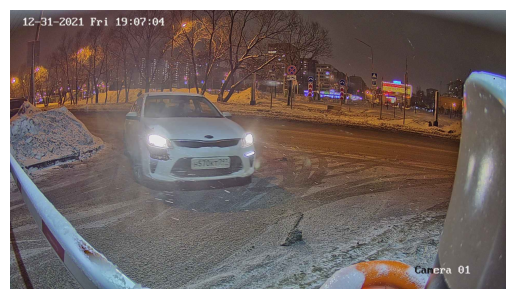

In [ ]:
image = Image.open('pics_jpg/' + filename)
plt.imshow(image)
plt.axis('off')
plt.show()

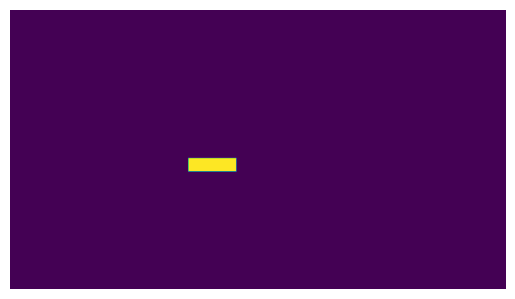

In [ ]:
image = Image.open('masks_jpg/' + filename)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# поделим изображения на train-test выборки.
!mkdir pics_jpg_to_train
!mkdir pics_jpg_to_test
!mkdir masks_jpg_to_train
!mkdir masks_jpg_to_test

pics_source_path = 'pics_jpg'
masks_source_path = 'masks_jpg'

train_path = '_to_train'
test_path = '_to_test'

test_size = 0.2

train_files, test_files = train_test_split(filenames,
                                           test_size=test_size,
                                           random_state=0)

In [ ]:
# скопируем картинки в соответсвующие папки

for dir in (pics_source_path, masks_source_path):
    for filename in tqdm(train_files):
        source_file = os.path.join(dir, filename)
        target_file = os.path.join(dir + train_path, filename)
        shutil.copyfile(source_file, target_file)

for dir in (pics_source_path, masks_source_path):
    for filename in tqdm(test_files):
        source_file = os.path.join(dir, filename)
        target_file = os.path.join(dir + test_path, filename)
        shutil.copyfile(source_file, target_file)

  0%|          | 0/3100 [00:00<?, ?it/s]

  0%|          | 0/3100 [00:00<?, ?it/s]

  0%|          | 0/775 [00:00<?, ?it/s]

  0%|          | 0/775 [00:00<?, ?it/s]

In [ ]:
# зафиксируем размер изображений, подаваемых на вход нейросети
Y = 480
X = 640

In [ ]:
# создадим генераторы изображений

data_gen_args = dict(rescale=1./255,)
                    #  rotation_range=10,
                    #  width_shift_range=0.15,
                    #  height_shift_range=0.15,
                    #  shear_range=0.15,
                    #  zoom_range=0.1,
                    #  horizontal_flip=False,
                    #  fill_mode='nearest')

flow_args = dict(classes=[''],
                 target_size = (Y, X),
                 batch_size = 8,
                 class_mode=None,
                 shuffle=False,)

pics_train_datagenerator = ImageDataGenerator(**data_gen_args)
masks_train_datagenerator = ImageDataGenerator(**data_gen_args)
pics_test_datagenerator = ImageDataGenerator(**data_gen_args)
masks_test_datagenerator = ImageDataGenerator(**data_gen_args)

pics_train_datagenerator = pics_train_datagenerator \
    .flow_from_directory('pics_jpg_to_train',
                         **flow_args)
masks_train_datagenerator = masks_train_datagenerator \
    .flow_from_directory('masks_jpg_to_train',
                         color_mode='grayscale',
                         **flow_args)
pics_test_datagenerator = pics_test_datagenerator \
    .flow_from_directory('pics_jpg_to_test',
                         **flow_args)
masks_test_datagenerator = masks_test_datagenerator \
    .flow_from_directory('masks_jpg_to_test',
                         color_mode='grayscale',
                         **flow_args)

train_generator = zip(pics_train_datagenerator,
                      masks_train_datagenerator)
test_generator = zip(pics_test_datagenerator,
                      masks_test_datagenerator)

# for pics, masks in train_generator:
#     print(f"Batch shape - pics: {pics.shape}, masks: {masks.shape}")

Found 3100 images belonging to 1 classes.
Found 3100 images belonging to 1 classes.
Found 775 images belonging to 1 classes.
Found 775 images belonging to 1 classes.


Для детекции номеров будем испольовать сеть архитектуры UNet

In [ ]:
# для оценки модели напишем свою версию метрики IoU

def iou(y_true, y_pred):
    """
    Функция для подсчёта метрики IoU на масках изображения
    """
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (tf.keras.backend.sum(y_true_f) \
                                         + tf.keras.backend.sum(y_pred_f) + 1.0)

In [ ]:
# Unet
inputs = Input(shape = (Y, X, 3))

conv1_1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
conv1_2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv1_1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1_2)

conv2_1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2_2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv2_1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2_2)

conv3_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv3_1)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3_2)

conv4_1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
conv4_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4_1)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4_2)


up1 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(pool4)
conc_1 = layers.Concatenate()([conv4_2, up1])
conv_up_1_1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conc_1)
conv_up_1_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv_up_1_1)

up2 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv_up_1_2)
conc_2 = layers.Concatenate()([conv3_2, up2])
conv_up_2_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conc_2)
conv_up_2_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv_up_2_1)

up3 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv_up_2_2)
conc_3 = layers.Concatenate()([conv2_2, up3])
conv_up_3_1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conc_3)
conv_up_3_2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv_up_3_1)

up4 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv_up_3_2)
conc_4 = layers.Concatenate()([conv1_2, up4])
conv_up_4_1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conc_4)
conv_up_4_2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv_up_4_1)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv_up_4_2)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(loss = 'binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001), metrics = [iou])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 640, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 480, 640, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

Создадим обратный вызов для тренировки модели

In [ ]:
class EarlyStopping(tf.keras.callbacks.Callback):

    def __init__(self, patience=5, save_dir=os.getcwd()):
        super(EarlyStopping, self).__init__()
        self.patience = patience
        self.best_iou = 0
        self.wait = 0
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        current_iou = logs['val_iou']
        if current_iou > self.best_iou:
            self.best_iou = current_iou
            self.wait = 0
            self.model.save(os.path.join(self.save_dir, 'best_model.h5'))
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print(' Тренировка остановлена: отсутствие роста IoU на валидационных данных.')


callbacks = [EarlyStopping(patience=10),]

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_files) // flow_args['batch_size'],
                    epochs=200,
                    validation_data=test_generator,
                    validation_steps=len(test_files) // flow_args['batch_size'],
                    callbacks=callbacks)

!cp best_model.h5 /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/best_model.h5

Epoch 1/200
387/387 [==============================] - 170s 373ms/step - loss: 0.0386 - iou: 0.0061 - val_loss: 0.0238 - val_iou: 0.0164
Epoch 2/200
387/387 [==============================] - 154s 385ms/step - loss: 0.0219 - iou: 0.0492 - val_loss: 0.0205 - val_iou: 0.0391
Epoch 3/200
387/387 [==============================] - 145s 375ms/step - loss: 0.0191 - iou: 0.0654 - val_loss: 0.0202 - val_iou: 0.0331
Epoch 4/200
387/387 [==============================] - 145s 376ms/step - loss: 0.0176 - iou: 0.0885 - val_loss: 0.0188 - val_iou: 0.0538
Epoch 5/200
387/387 [==============================] - 144s 372ms/step - loss: 0.0158 - iou: 0.1281 - val_loss: 0.0175 - val_iou: 0.2168
Epoch 6/200
387/387 [==============================] - 147s 381ms/step - loss: 0.0122 - iou: 0.3191 - val_loss: 0.0121 - val_iou: 0.3612
Epoch 7/200
387/387 [==============================] - 148s 382ms/step - loss: 0.0100 - iou: 0.3880 - val_loss: 0.0083 - val_iou: 0.5123
Epoch 8/200
387/387 [====================

In [ ]:
!cp -r /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/best_model.h5 .

model = tf.keras.models.load_model('best_model.h5', compile=False)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=[iou])

Сделаем маску для всех исходных изображений и оценим результат

In [ ]:
def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_value = np.sum(intersection) / np.sum(union)
    return iou_value

if not os.path.exists('masks_jpg_predict'):
    !mkdir masks_jpg_predict
else:
    shutil.rmtree('masks_jpg_predict')

path_to_pics_array = []
path_to_true_mask_array = []
path_to_pred_mask_array = []
iou_array = []

for pics_name in tqdm(filenames):

    path_to_pics = os.path.join('pics_jpg', pics_name)
    path_to_true_mask = os.path.join('masks_jpg', pics_name)

    path_to_pics_array.append(path_to_pics)
    path_to_true_mask_array.append(path_to_true_mask)

    image = Image.open(path_to_pics)
    mask = Image.open(path_to_true_mask)

    size = image.size

    image = np.array(image) / 255.
    mask = np.array(mask) / 255.

    pics_resize = cv2.resize(image,
                             (X, Y),
                             interpolation=cv2.INTER_NEAREST)

    pics_resize = pics_resize.reshape(-1, 480, 640, 3)

    pred_proba = model.predict(pics_resize)

    pred = ((pred_proba > 0.5).astype(int) * 255).reshape(Y, X, 1)

    pred = cv2.resize(pred,
                      size,
                      interpolation=cv2.INTER_NEAREST)

    cur_iou = iou(mask, pred.astype('float64'))
    iou_array.append(cur_iou)

    mask_name = pics_name.split('.')[0] + '_mask.jpg'
    path_to_pred_mask = os.path.join('masks_jpg_predict', mask_name)
    path_to_pred_mask_array.append(path_to_pred_mask)

    cv2.imwrite(path_to_pred_mask, pred)

df_result = pd.DataFrame(data={
    'path_to_pics'      : path_to_pics_array,
    'path_to_true_mask' : path_to_true_mask_array,
    'path_to_pred_mask' : path_to_pred_mask_array,
    'iou'               : iou_array
})

  0%|          | 0/3875 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


<ipython-input-18-51d77d15cede>:4: RuntimeWarning: invalid value encountered in long_scalars
  iou_value = np.sum(intersection) / np.sum(union)


1/1 [==============================] - 1s 896ms/step


In [ ]:
df_result.head(2)

,path_to_pics,path_to_true_mask,path_to_pred_mask,iou
0,pics_jpg/photo_45009@11-01-2022_20-31-19_0.jpg,masks_jpg/photo_45009@11-01-2022_20-31-19_0.jpg,masks_jpg_predict/photo_45009@11-01-2022_20-31...,NaN
1,pics_jpg/photo_36206@31-12-2021_21-06-51_168.jpg,masks_jpg/photo_36206@31-12-2021_21-06-51_168.jpg,masks_jpg_predict/photo_36206@31-12-2021_21-06...,0.794164


In [ ]:
df_result.to_csv('detection_result.csv', index=False)
shutil.make_archive('masks_jpg_predict', 'zip', 'masks_jpg_predict')

!cp masks_jpg_predict.zip /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/masks_jpg_predict.zip
!cp detection_result.csv /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/detection_result.csv

In [ ]:
df_result[df_result['iou'] == df_result['iou'].min()]

,path_to_pics,path_to_true_mask,path_to_pred_mask,iou
7,pics_jpg/photo_38061@03-01-2022_23-18-32_0.jpg,masks_jpg/photo_38061@03-01-2022_23-18-32_0.jpg,masks_jpg_predict/photo_38061@03-01-2022_23-18...,0.0
60,pics_jpg/photo_37309@02-01-2022_18-40-35_450.jpg,masks_jpg/photo_37309@02-01-2022_18-40-35_450.jpg,masks_jpg_predict/photo_37309@02-01-2022_18-40...,0.0
78,pics_jpg/photo_2021-12-17_10-18-10 (2).jpg,masks_jpg/photo_2021-12-17_10-18-10 (2).jpg,masks_jpg_predict/photo_2021-12-17_10-18-10 (2...,0.0
141,pics_jpg/photo_85315@13-02-2022_17-25-56.jpg,masks_jpg/photo_85315@13-02-2022_17-25-56.jpg,masks_jpg_predict/photo_85315@13-02-2022_17-25...,0.0
146,pics_jpg/photo_37623@03-01-2022_13-01-03_203.jpg,masks_jpg/photo_37623@03-01-2022_13-01-03_203.jpg,masks_jpg_predict/photo_37623@03-01-2022_13-01...,0.0
...,...,...,...,...
3782,pics_jpg/photo_18501@16-12-2021_11-15-09.jpg,masks_jpg/photo_18501@16-12-2021_11-15-09.jpg,masks_jpg_predict/photo_18501@16-12-2021_11-15...,0.0
3787,pics_jpg/photo_45181@11-01-2022_22-51-14_0.jpg,masks_jpg/photo_45181@11-01-2022_22-51-14_0.jpg,masks_jpg_predict/photo_45181@11-01-2022_22-51...,0.0
3833,pics_jpg/photo_37194@02-01-2022_16-03-49_126.jpg,masks_jpg/photo_37194@02-01-2022_16-03-49_126.jpg,masks_jpg_predict/photo_37194@02-01-2022_16-03...,0.0
3858,pics_jpg/photo_88732@15-02-2022_10-23-48.jpg,masks_jpg/photo_88732@15-02-2022_10-23-48.jpg,masks_jpg_predict/photo_88732@15-02-2022_10-23...,0.0


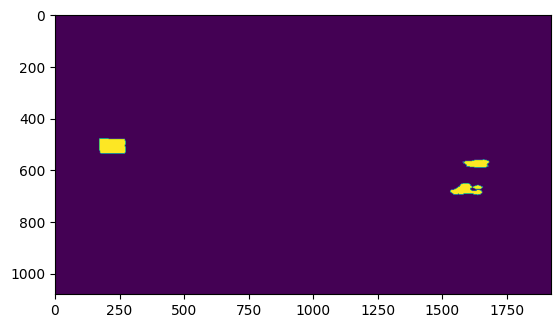

In [ ]:
image = Image.open(df_result.iloc[7][2])
plt.imshow(image)